In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import quandl as ql
import statsmodels.formula.api as smf
pd.set_option('display.float_format', lambda x: '%.9f' % x)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
ql.ApiConfig.api_key = os.getenv('QUANDL_API_KEY')

In [2]:
# Check contents of API key
type(ql.ApiConfig.api_key)

str

 # Return Forecasting:  Read Historical Daily Yen Futures Data from Quandl
 In this activity, you will pull historical Dollar-Yen exchange rate futures data from Quandl and test whether there is any predictable behavior using time-series models.

 * First, you'll need to download the futures data using the Quandl API, and return it as a Pandas DataFrame.
 * You'll need a Quandl API key (free): https://www.quandl.com/
 * (Use code "CHRIS/CME_JY1")
 * Trim the resulting data to include only from the the year 1990 through today.

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
fut = ql.get('CHRIS/CME_JY1',authtoken=ql.ApiConfig.api_key)
fut.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.000000000,3401.000000000,3398.000000000,3401.000000000,nan,3401.000000000,2.000000000,1.000000000
1976-08-03,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000
1976-08-04,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000
1976-08-05,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000
1976-08-06,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000


In [4]:
# Trim the dataset to begin on January 1st, 1990
fut =  data = ql.get('CHRIS/CME_JY1', trim_start = '1990-01-01', authtoken=ql.ApiConfig.api_key) 
fut.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.000000000,6954.000000000,6835.000000000,6847.000000000,nan,6847.000000000,48336.000000000,51473.000000000
1990-01-03,6877.000000000,6910.000000000,6865.000000000,6887.000000000,nan,6887.000000000,38206.000000000,53860.000000000
1990-01-04,6937.000000000,7030.000000000,6924.000000000,7008.000000000,nan,7008.000000000,49649.000000000,55699.000000000
1990-01-05,6952.000000000,6985.000000000,6942.000000000,6950.000000000,nan,6950.000000000,29944.000000000,53111.000000000
1990-01-08,6936.000000000,6972.000000000,6936.000000000,6959.000000000,nan,6959.000000000,19763.000000000,52072.000000000


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

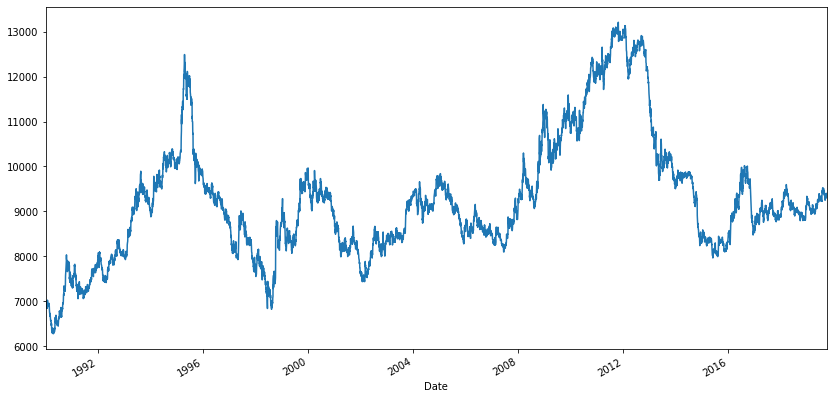

In [5]:
# Plot just the "Settle" column from the dataframe:
fut['Settle'].plot(figsize=(14,7))

# Save image of chart
plt.savefig('japanese_yen_settle_price.png', bbox_inches = 'tight')

### Do you see any patterns, long-term and/or short?

The long term pattern could be described as positive, however, when broken up into time periods, it is pretty volatile.

 # Return Forecasting: MA/EWMA Smoothing of Futures Prices

 1. Plot the Settle Price, along with a moving average of 15 and 60 days. Use indexing to just plot the data from 2015 onward.
 2. What do you see now, in terms of short versus long-term trends?
 3. Try an exponential moving average, with a half life of 15 days.
 4. Which seems to respond faster, an exponential moving average with a half life of 15 days, or a moving average of 15 days?

 (15 days = 3 weeks)
 (60 days = 3 months)

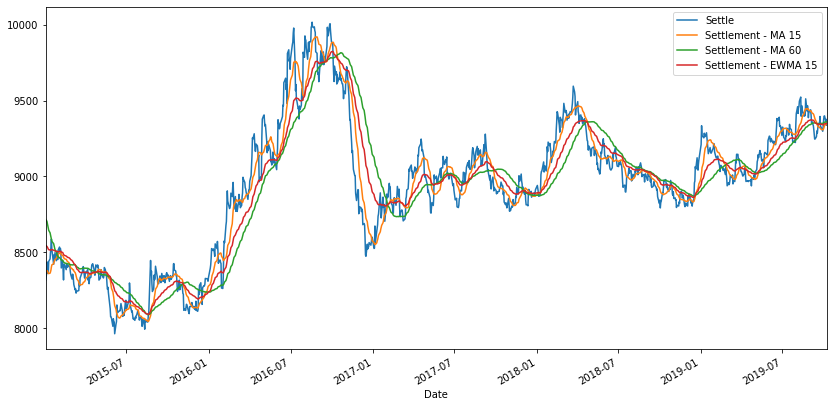

In [6]:
###### Moving averages and exponentially weighted moving averages 
# Create a dataframe using just the "Settle" price
settle_df=fut[['Settle']].copy()

# Add in columns for moving average windows of 15 and 60 days, and a column for an EWMA window of 15 days
settle_df['Settlement - MA 15'] = settle_df['Settle'].rolling(window=15).mean()
settle_df['Settlement - MA 60'] = settle_df['Settle'].rolling(window=60).mean()
settle_df['Settlement - EWMA 15'] = settle_df['Settle'].ewm(halflife=15).mean()

# Plot the settle price and moving average/ewma columns all in one plot from 2015:
settle_df['2015':].plot(figsize=(14,7))

# Save image of chart
plt.savefig('all_settle_price', bbox_inches = 'tight')

### What do you see now, in terms of short versus long-term trends?

Since we have zoomed in to the time period after 2015, it seems it has still been mostly positive, as well as having stabalized a bit after January of 2017.

### Which seems to respond faster, an exponential moving average with a half life of 15 days, or a moving average of 15 days?

A moving average of 15 days seems to respond faster than the exponential moving average.

# Return Forecasting: Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [7]:
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend =  sm.tsa.filters.hpfilter(settle_df['Settle']['2015':])

# Create a dataframe of just the settle price, and add in the "noise" and "trend" series from above:
futures_decomp = settle_df['2015':]
futures_decomp.head()

,Settle,Settlement - MA 15,Settlement - MA 60,Settlement - EWMA 15
Date,,,,
2015-01-02,8315.000000000,8378.333333333,8718.683333333,8546.156406984
2015-01-05,8371.000000000,8376.600000000,8704.033333333,8538.246624580
2015-01-06,8435.000000000,8377.533333333,8689.900000000,8533.584172612
2015-01-07,8412.000000000,8371.400000000,8675.450000000,8528.093626387
2015-01-08,8360.000000000,8359.466666667,8659.616666667,8520.502787827


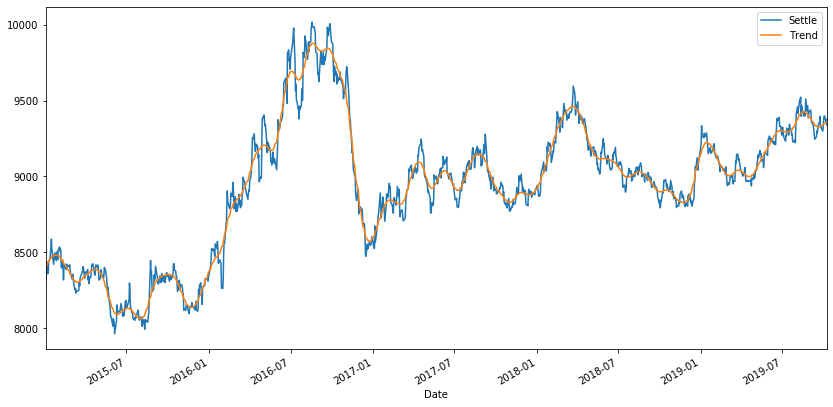

In [8]:
futures_decomp['Noise'] = ts_noise 
futures_decomp['Trend'] = ts_trend 
futures_decomp.drop(columns=['Settlement - MA 15','Settlement - MA 60','Settlement - EWMA 15'],inplace=True)

# Plot the "Settle" and "Trend" price 
futures_decomp.drop(columns='Noise').plot(figsize=(14,7))

# Save image of chart
plt.savefig('settle_and_trend_price', bbox_inches = 'tight')

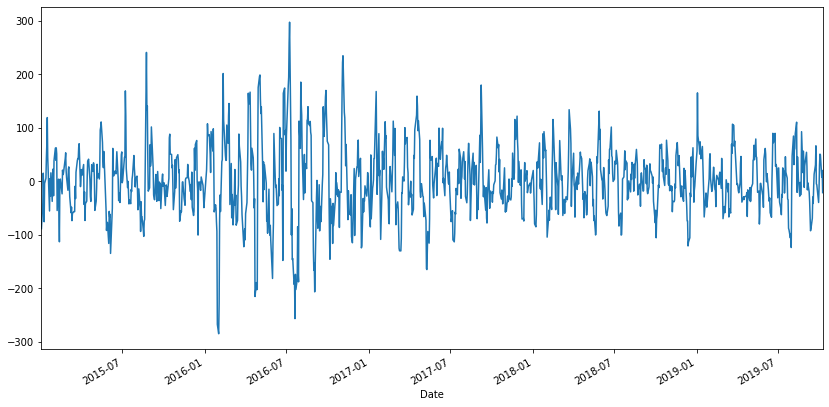

In [9]:
# Then plot the "noise" separately
futures_decomp['Noise'].plot(figsize=(14,7))

# Save image of chart
plt.savefig('settle_price_noise', bbox_inches = 'tight')

 # Return Forecasting: Seasonal Effects with Sklearn Linear Regression
 Using the full dataset, use a SKLearn linear regression to predict Yen futures ("settle") returns with *lagged* Yen futures returns and categorical calendar seasonal effects (e.g., day-of-week or week-of-year seasonal effects).


In [10]:
#Use the dataframe containing "Settle" Prices:
fut.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.000000000,6954.000000000,6835.000000000,6847.000000000,nan,6847.000000000,48336.000000000,51473.000000000
1990-01-03,6877.000000000,6910.000000000,6865.000000000,6887.000000000,nan,6887.000000000,38206.000000000,53860.000000000
1990-01-04,6937.000000000,7030.000000000,6924.000000000,7008.000000000,nan,7008.000000000,49649.000000000,55699.000000000
1990-01-05,6952.000000000,6985.000000000,6942.000000000,6950.000000000,nan,6950.000000000,29944.000000000,53111.000000000
1990-01-08,6936.000000000,6972.000000000,6936.000000000,6959.000000000,nan,6959.000000000,19763.000000000,52072.000000000


In [11]:
from sklearn.linear_model import LinearRegression

# Construct a "Futures Return" column, using pandas pct_change() on the "Settle" price 
# It will be easier to also multiply this by 100, both to read and when we use it with SKLearn:
fut['Futures Return'] = fut['Settle'].copy().pct_change()*100

# Feature Engineering
# Create a second "Lagged Return" variable, that is the futures return variable shifted above, but lagged 1 day:
# We'll use this lagged return as the feature vector X:
fut['Lagged Return'] = (fut['Settle'].copy().pct_change()*100).shift()
fut = fut.replace(-np.inf, np.nan).dropna()

# Construct a new "X" dataframe using just the "Lagged Return" variable:
X = fut['Lagged Return'].to_frame()

In [12]:
# Add into the X dataframe either a "dayofweek" or "weekofyear" column, (e.g., using X.index.weekofyear) 
X['Week_of_Year'] = X.index.weekofyear

# Create a new categorical X dataframe, by using pd.get_dummies() on the seasonal column created just above:
X_binary_encoded = pd.get_dummies(X, columns=['Week_of_Year'],drop_first=True)
X_binary_encoded.head()

,Lagged Return,Week_of_Year_2,Week_of_Year_3,Week_of_Year_4,Week_of_Year_5,Week_of_Year_6,Week_of_Year_7,Week_of_Year_8,Week_of_Year_9,Week_of_Year_10,...,Week_of_Year_44,Week_of_Year_45,Week_of_Year_46,Week_of_Year_47,Week_of_Year_48,Week_of_Year_49,Week_of_Year_50,Week_of_Year_51,Week_of_Year_52,Week_of_Year_53
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-18,0.409123453,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-19,-0.427829276,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-20,-0.020460358,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-21,0.020464545,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-24,-0.204603581,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Create a "y" series, using just the "Futures Return" column created above.
y = fut["Futures Return"].copy()

# Construct a "LinearRegression" object:
model = LinearRegression()

# Fit a model using the X and y objects:
model.fit(X_binary_encoded, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [14]:
# Construct predictions based on the X object:
predictions = model.predict(X_binary_encoded)
predictions

array([-0.09345819, -0.05400652, -0.07320878, ...,  0.07617032,
        0.0967315 ,  0.06911629])

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
# Calculate r2_score (r-squared)
r2 = r2_score(y, predictions)

# Calculate mean squared error 
# (A "good" MSE score will be close to zero while a "good" R2 Score will be close to 1.)
mse = mean_squared_error(y, predictions) 

# Using mean squared eror above, calculate root-mean-squared error (RMSE)
rmse = np.sqrt(mse) 

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Standard Deviation of Futures Return: {y.std()}")

Mean Squared Error (MSE): 0.2832743715945907
R-squared (R2): 0.04919945433764128
Root Mean Squared Error (RMSE): 0.5322352596311059
Standard Deviation of Futures Return: 0.546025445415136


### Summarize the quality of your model using R2 and root-mean-squared-error (RMSE) statistics. How good is it?

With a R2 of 0.049 and RMSE of 0.53, the model could be described as not very good.

 #### Plotting and Independent (X) Variable Interpretation

 Plot the model predictions of returns against actual returns, for just data from 2018 onward.

In [16]:
# Create a "y" dataframe, using just the "Futures Return" column created above. 
y_df = y.to_frame()

# Add the model predictions from above as an additional column to that dataframe:
y_df["prediction"] = predictions 
y_df.head()

,Futures Return,prediction
Date,,
2014-02-18,-0.427829276,-0.093458188
2014-02-19,-0.020460358,-0.054006524
2014-02-20,0.020464545,-0.073208782
2014-02-21,-0.204603581,-0.075137870
2014-02-24,0.020502307,-0.066382647


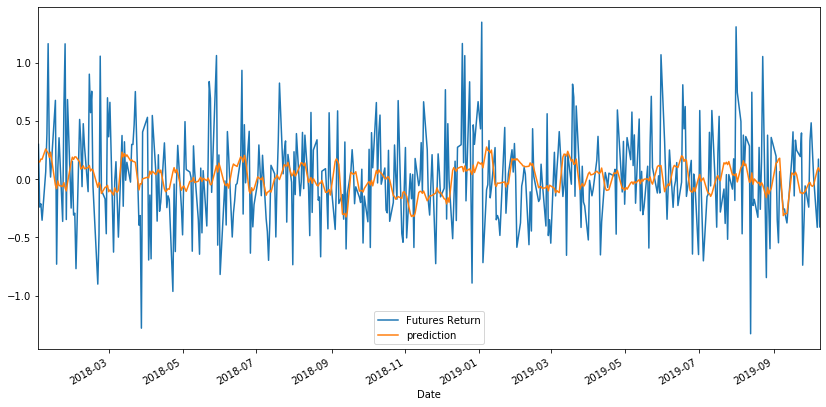

In [17]:
# Plot the two from 2018 onward
y_df['2018':].plot(figsize=(14,7))

# Save image of chart
plt.savefig('futures_return_and_prediction.png', bbox_inches = 'tight')

 Separately, plot the calendar effects estimated from the model using matplotlib. Do you see any seasonal patterns?

In [18]:
# Construct a dataframe of the model calendar-effect coefficients and review the output:
results = pd.DataFrame(model.coef_, columns=['Coefficient'], index=X_binary_encoded.columns)

# Filter results so that it only includes either the day-of-week or week-of-year effect 
results = (results[results.index.str.contains('Week_of_Year')])

results.head(10)

,Coefficient
Week_of_Year_2,0.081178409
Week_of_Year_3,-0.211048541
Week_of_Year_4,-0.207719167
Week_of_Year_5,0.015616153
Week_of_Year_6,-0.049868534
Week_of_Year_7,-0.048521800
Week_of_Year_8,-0.234090714
Week_of_Year_9,-0.235944588
Week_of_Year_10,-0.266025004
Week_of_Year_11,0.047185901


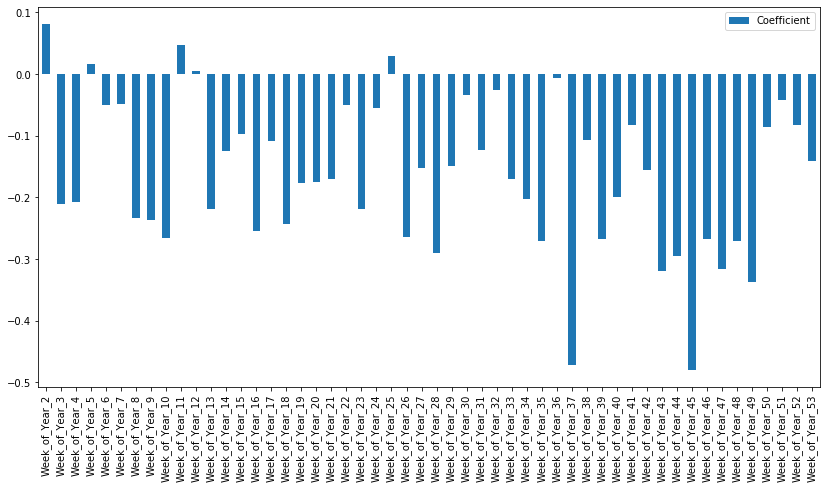

In [19]:
# Plot the results of the individual seasonal effects using pandas df.plot()
results.plot(figsize=(14,7),kind="bar")

# Save image of chart
plt.savefig('return_coefficient.png', bbox_inches = 'tight')

### Do you see any seasonal patterns?

In my opinion, the only instances that could indicate a significant seasonal pattern, are between the weeks 43 and 49.

 # Return Forecasting: Autocorrelation and the ARMA Model

 Using futures Settle *Returns*, estimate an ARMA model.
 1. Set the AR and MA ("p" and "q") parameters to p=2 and q=1.
 2. Plot autocorrelation and partial correlation graphs with an alpha of 0.10 and lags=30. If, when looking at the correlation graphs, additional lags seem important for predicting returns, increase the number of lags in the ARMA model from (1).
 3. Does increasing the number of "p" or "q" increase the ability of the model? Compare your results between the two models by comparing the Bayseian Information Criterion, or BIC.

In [20]:
import statsmodels.api as sm

# Import the ARMA model
from statsmodels.tsa.arima_model import ARMA

# Create a series using "Settle" price percentage returns, and drop any nan's:
df = fut[["Settle"]].pct_change().dropna()

# Estimate and ARMA model using statsmodels
# Hint: ARMA(df, order=(p, q)).fit()
autoregressive_count = 2
moving_average_window = 1
model = ARMA(df.Settle, order=(autoregressive_count,moving_average_window)).fit()
model

In [21]:
# Output model summary results:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 1410
Model:                     ARMA(2, 1)   Log Likelihood                5347.586
Method:                       css-mle   S.D. of innovations              0.005
Date:                Thu, 10 Oct 2019   AIC                         -10685.172
Time:                        00:44:22   BIC                         -10658.915
Sample:                             0   HQIC                        -10675.360
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.771e-05      0.000     -0.116      0.908      -0.000       0.000
ar.L1.Settle     0.2980      0.339      0.880      0.379      -0.366       0.962
ar.L2.Settle     0.0464      0.027      1.746      0.081      -0.006       0.099
ma.L1.Settle    -0.3117      0.338     -0.921      0.357      -0.975       0.352
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4334           +0.0000j            2.4334            0.0000
AR.2           -8.8529           +0.0000j            8.8529            0.5000
MA.1            3.2083           +0.0000j            3.2083            0.0000
-----------------------------------------------------------------------------
"""

In [22]:
# Import plot_acf and plot_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

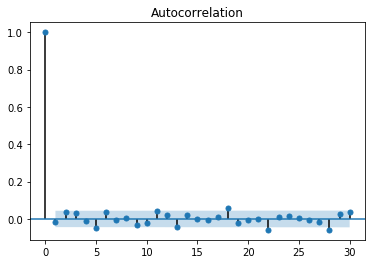

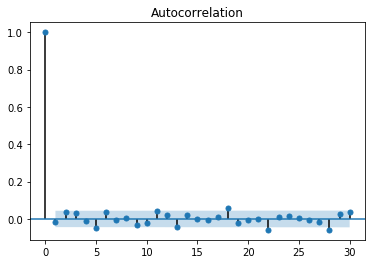

In [23]:
# Plot autocorrelation and partial correlation graphs with an alpha of 0.10 and lags=30.

# Autocorrelation (For detecting # of MA ("P") Lags)
plot_acf(df.Settle, lags=30, alpha=0.10)

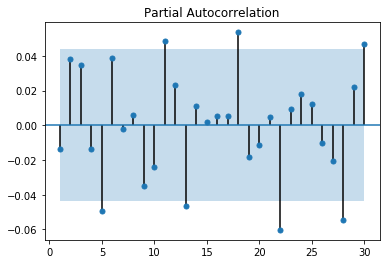

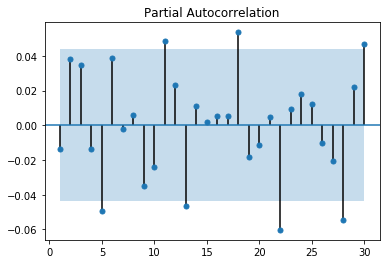

In [24]:
# Partial Autocorrelation (For detecting # of MA ("P") Lags)
plot_pacf(df.Settle, lags=30, alpha=0.10, zero=False)

In [25]:
autoregressive_count = 10
moving_average_window = 5

# Esimate your model based on your interpretation of the autocorrelation/partial autocorrelation plots:
model_02 = ARMA(df.Settle, order=(autoregressive_count,moving_average_window)).fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [26]:
# Review model summary results:
model_02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 1410
Model:                    ARMA(10, 5)   Log Likelihood                5360.895
Method:                       css-mle   S.D. of innovations              0.005
Date:                Thu, 10 Oct 2019   AIC                         -10687.791
Time:                        00:46:13   BIC                         -10598.518
Sample:                             0   HQIC                        -10654.430
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.097e-05      0.000     -0.144      0.885      -0.000       0.000
ar.L1.Settle     -0.8082      0.103     -7.858      0.000      -1.010      -0.607
ar.L2.Settle     -1.0399      0.026    -40.157      0.000      -1.091      -0.989
ar.L3.Settle     -0.9284      0.119     -7.799      0.000      -1.162      -0.695
ar.L4.Settle     -0.8127      0.053    -15.454      0.000      -0.916      -0.710
ar.L5.Settle     -0.8568      0.103     -8.308      0.000      -1.059      -0.655
ar.L6.Settle      0.0111      0.056      0.197      0.844      -0.099       0.121
ar.L7.Settle     -0.0009      0.050     -0.018      0.986      -0.100       0.098
ar.L8.Settle      0.0038      0.047      0.082      0.935      -0.087       0.095
ar.L9.Settle     -0.0575      0.035     -1.640      0.101      -0.126       0.011
ar.L10.Settle    -0.0549      0.031     -1.743      0.081      -0.117       0.007
ma.L1.Settle      0.7920      0.098      8.065      0.000       0.599       0.984
ma.L2.Settle      1.0752        nan        nan        nan         nan         nan
ma.L3.Settle      0.9885      0.115      8.601      0.000       0.763       1.214
ma.L4.Settle      0.8702      0.013     66.509      0.000       0.845       0.896
ma.L5.Settle      0.8759      0.091      9.631      0.000       0.698       1.054
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.4782           -0.8819j            1.0032           -0.1709
AR.2             0.4782           +0.8819j            1.0032            0.1709
AR.3             1.5090           -0.9343j            1.7748           -0.0882
AR.4             1.5090           +0.9343j            1.7748            0.0882
AR.5            -0.4377           -0.9394j            1.0364           -0.3194
AR.6            -0.4377           +0.9394j            1.0364            0.3194
AR.7            -1.0785           -0.0000j            1.0785           -0.5000
AR.8            -0.5849           -1.5072j            1.6167           -0.3089
AR.9            -0.5849           +1.5072j            1.6167            0.3089
AR.10           -1.8984           -0.0000j            1.8984           -0.5000
MA.1             0.4744           -0.8848j            1.0039           -0.1717
MA.2             0.4744           +0.8848j            1.0039            0.1717
MA.3            -1.0940           -0.0000j            1.0940           -0.5000
MA.4            -0.4241           -0.9249j            1.0175           -0.3184
MA.5            -0.4241           +0.9249j            1.0175            0.3184
------------------------------------------------------------------------------
"""

### Does increasing the number of "p" or "q" increase the ability of the model?

It does not because the number goes from a negative number, to a smaller negative number. For example, with autoregressive_count of 2 and a moving average window of 1 versus autoregressive_count of 10 and moving average window of 5, the BIC goes from -10658.915 to -10598.518.

 # Return Forecasting: Deploying the ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags

 2. Plot the residuals from the model. If residuals are the part of returns that our model *doesn"t* explain, does it seem like our model has missed any seasonality?
 3. Construct a 15 day (3 week) forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [27]:
# For ARIMA, construct a dataframe using just the futures "Settle" prices:
df = fut['Settle'].to_frame()
df.head()

,Settle
Date,
2014-02-18,9775.000000000
2014-02-19,9773.000000000
2014-02-20,9775.000000000
2014-02-21,9755.000000000
2014-02-24,9757.000000000


                             ARIMA Model Results                              
Dep. Variable:               D.Settle   No. Observations:                 1410
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -7489.597
Method:                       css-mle   S.D. of innovations             49.049
Date:                Thu, 10 Oct 2019   AIC                          14995.194
Time:                        00:46:24   BIC                          15037.205
Sample:                             1   HQIC                         15010.893
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.3115      1.332     -0.234      0.815      -2.922       2.299
ar.L1.D.Settle    -0.5831      0.313     -1.860      0.063      -1.197       0.031
ar.L2.D.Settle     0.0394      0.031

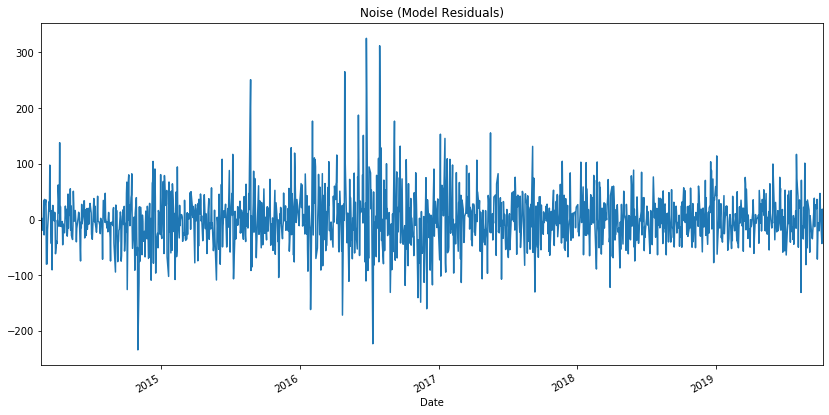

count   1410.000000000
mean       0.001296135
std       49.066559670
min     -234.073976914
25%      -27.672396918
50%       -0.827164750
75%       25.436070236
max      325.327344954
dtype: float64


In [28]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(df, order=(5, 1, 1))
model_fit = model.fit()

# Output model summary results:
print(model_fit.summary())

## plot residual errors:
residuals = model_fit.resid
residuals.plot(figsize=(14,7),title="Noise (Model Residuals)")
plt.show()
print(residuals.describe())

### If residuals are the part of returns that our model doesn't explain, does it seem like our model has missed any seasonality?

Based off of the graph, it does not seem like our model has missed any seasonality.

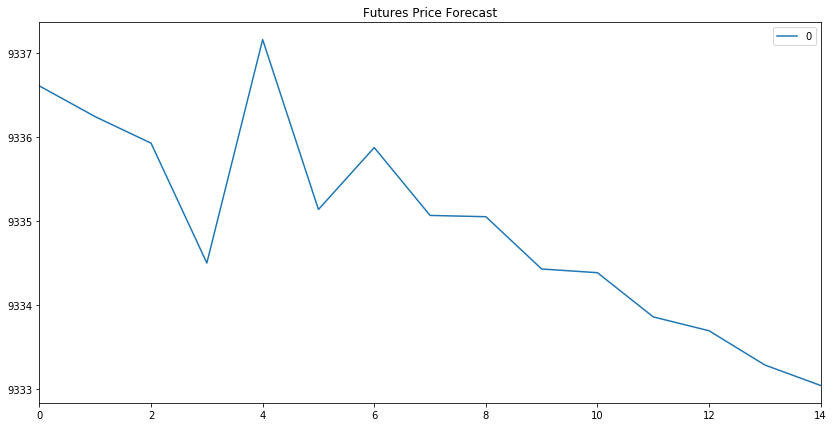

In [29]:
# Construct a 15 day (3 week) forecast for the Settle Price.
# Specifically, construct a pandas DataFrame containing ARIMA model forecasts for a 15-day window:
pd.DataFrame(model_fit.forecast(steps=15)[0]).plot(figsize=(14,7),title="Futures Price Forecast")

# Save image of chart
plt.savefig('futures_price_forecast.png', bbox_inches = 'tight')

### What does the model forecast will happen to the Japanese Yen in the near term?

According to the futures price graph, in the coming six days, the Yen will experience some volatility before ultimately plummeting for the rest of the nine days.

 # Volatility Forecasting

 Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.

### Volatility Forecasting: GARCH and EGARCH Models
Using the "arch" package, estimate either GARCH(1,1) or an EGARCH(p,q) volatility forecast model on futures settle returns.

In [30]:
import arch as arch
from arch import arch_model

In [31]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by *100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns=(fut[["Settle"]].pct_change()*100)
returns=returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-03,0.256040967
2019-10-04,0.021282256
2019-10-07,-0.414915687
2019-10-08,0.170931040
2019-10-09,-0.410600971


In [32]:
# Estimate a GARCH(1,1) model using the "arch" package:
# (We need to drop all NaN"s first in order to get this to run):
am = arch_model(returns, mean="Constant", vol="GARCH", p=1, q=1) 
res = am.fit(disp="off")

In [33]:
# Output the summary results of the GARCH model:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Settle   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1067.10
Distribution:                  Normal   AIC:                           2142.20
Method:            Maximum Likelihood   BIC:                           2163.20
                                        No. Observations:                 1410
Date:                Thu, Oct 10 2019   Df Residuals:                     1406
Time:                        00:46:38   Df Model:                            4
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -3.6683e-03  1.252e-02     -0.293      0.

### Volatility Forecasting: Identifying Patterns of Clustered Volatility

GARCH/EGARCH, etc. models are good for capturing the "volatility clustering" effect that is common in financial data. After estimating your model, can you identify periods when volatility clusters together?

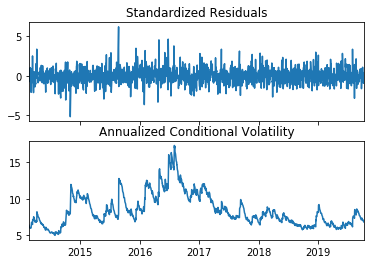

In [34]:
# Plot the model"s conditional volatility for the Yen:
# Hint: use .plot(annualize="D")
fig = res.plot(annualize='D')

### After estimating your model, can you identify periods when volatility clusters together?

Yes, when looking at the Annualized Conditional Volatility graph, you can see instances where the volatiltiy clusters together. However, it is not reflective of seasonality because it tends to happen a bit randomly throughout the years.

### Volatility Forecasting: 3-day Yen Volatility Forecasts using GARCH/EGARCH
  * Let's do some forecasting of near-term risk. Specifically, use the .forecast() method to calculate 3-day forecasts. Then plot the resulting 3-day annualized variance. Is Yen volatility expected to rise or fall in the near term?

In [35]:
# Note--You can either specify today"s date manually, or use pd.datetime.today().strftime("%Y-%m-%d") 
# (example format: start="2019-06-28")
# If you have problems with datetime, 
# specify data date manually using the most recent trading date in the dataframe
todays_date = returns.index.max().strftime('%Y-%m-%d')
# todays_date = pd.datetime.today().strftime("%Y-%m-%d")                  
# todays_date = '2019-10-09'

# Forecast volatility, from today"s date until the following three days:
forecast_horizon = 3 
forecasts = res.forecast(horizon=forecast_horizon, start=todays_date) 
forecasts

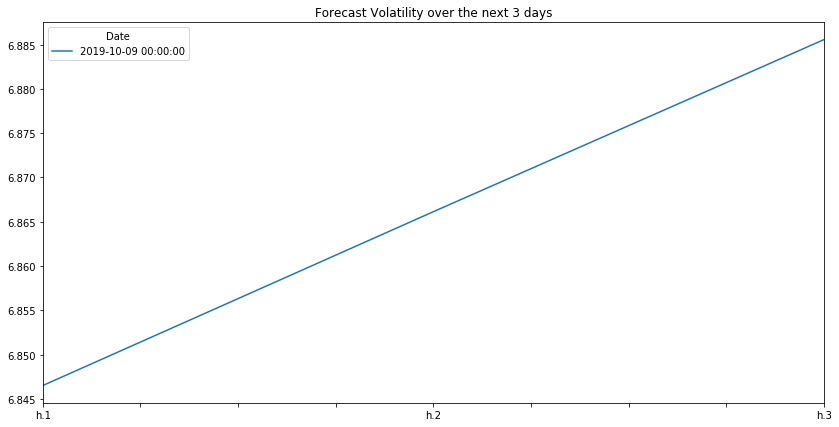

In [36]:
# Plot the annualized volatility forecast using pd.plot():
# (Make sure to use dropna() on the forecasts before plotting):
# (There are 252 trading days in a year)
# Note: each column in forecasts.variance represents one day ahead: 
plot_title = f"Forecast Volatility over the next {forecast_horizon} days"
model_forecasts = np.sqrt(forecasts.variance.dropna() * 252)
model_forecasts.dropna().T.plot(figsize=(14,7),title=plot_title)

# Save image of chart
plt.savefig('forecast_volatility_three_days.png', bbox_inches = 'tight')

### Is Yen volatility expected to rise or fall in the near term?

The volatility is expected to rise because the variance is expected to increase in the following three days.

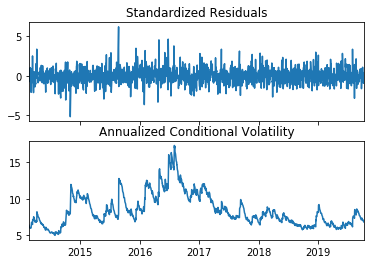

In [37]:
# This plot shows the exact same info as the previous two
# graphs showing residuals and volatility. Inclcuded because
# it was shown in the homework template.

fig = res.plot(annualize='D')

 # Out-of-Sample Predictions (Optional)
 So far, you"ve used the full dataset to construct a model. Let's try a more rigorous technique.

### Out-of-Sample Predictions: Slicing the Data into Training and Test Set ("One Shot" Approach)

Using the SKLearn regression model and just lagged returns as the independent variable, start by estimating a model using **training data** from January, 2015 through December 2017.

In [75]:
# If you haven"t already, create and add "Futures Return" and "Lagged Futures Return" variables to your dataframe:
# Replace inf, -inf with np.nan, then drop any row with at least one np.nan in the dataframe
fut["Futures Return"] = # YOUR CODE HERE 
fut["Lagged Return"] = # YOUR CODE HERE 
fut = fut.replace(-np.inf, np.nan).dropna()
fut[["Futures Return", "Lagged Return"]].head()

,Futures Return,Lagged Return
Date,,
2014-03-04,-0.801298306,0.346055980
2014-03-06,-0.766871166,-0.801298306
2014-03-07,-0.247295209,-0.766871166
2014-03-10,0.103295114,-0.247295209
2014-03-11,0.278609019,0.103295114


In [76]:
# Using datetime index slicing, create a "training" data dataframe using data from just 2015-01-01 to 2017-12-31
train = # YOUR CODE HERE 
print("Training set covers from ", train.index.min(), " to ", train.index.max())
train.head(2)

Training set covers from  2015-01-02 00:00:00  to  2017-12-29 00:00:00


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Futures Return,Lagged Return
Date,,,,,,,,,,
2015-01-02,8352.000000000,8353.000000000,8286.000000000,8310.000000000,34.000000000,8315.000000000,101438.000000000,222022.000000000,-0.407234399,-0.262812089
2015-01-05,8305.000000000,8382.000000000,8293.000000000,8371.000000000,56.000000000,8371.000000000,165487.000000000,226085.000000000,0.673481660,-0.407234399


In [77]:
# Using datetime index slicing, create a "test" data dataframe using data from 2018-01-01 through the end of the data
test = # YOUR CODE HERE 
print("Test set covers from ", test.index.min(), " to ", test.index.max())
test.head(2)

Test set covers from  2018-01-02 00:00:00  to  2019-07-05 00:00:00


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Futures Return,Lagged Return
Date,,,,,,,,,,
2018-01-02,8909.500000000,8957.500000000,8898.500000000,8938.000000000,26.500000000,8940.500000000,96714.000000000,227884.000000000,0.297285169,0.224870699
2018-01-03,8943.000000000,8947.500000000,8913.000000000,8921.000000000,21.500000000,8919.000000000,93498.000000000,226582.000000000,-0.240478720,0.297285169


  * Then use the model developed on a test set using data from 2018 onward.

In [78]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = # YOUR CODE HERE 
y_train = # YOUR CODE HERE 
X_test = # YOUR CODE HERE 
y_test = # YOUR CODE HERE 

In [79]:
# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
# YOUR CODE HERE 

# Score how that model works using only the test data
# YOUR CODE HERE 

# And make a prediction of "y" values for just the test dataset
predictions = # YOUR CODE HERE 

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

In [80]:
Results.head()

,Futures Return,Predicted Return
Date,,
2018-01-02,0.297285169,0.004644804
2018-01-03,-0.240478720,0.002612746
2018-01-04,-0.213028366,0.017703208
2018-01-05,-0.353932584,0.016932910
2018-01-08,0.062017252,0.020886894



  * Compare the RMSE from the model using the test sample to the RMSE when using the full-sample. Are the results surprising?

In [81]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe above)
mse = # YOUR CODE HERE 

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
one_shot_rmse = # YOUR CODE HERE 
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {one_shot_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.40994570155874877


In [82]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = # YOUR CODE HERE 

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = # YOUR CODE HERE 

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = # YOUR CODE HERE 
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.6257993297323167


### Out-of-Sample Predictions: The Rolling Out-of-Sample Approach

Let's take the model above (i.e., SKLearn predicting futures returns with lagged futures returns), but apply it using a rolling, out of sample approach. This method, which is specific to time-series predictions, will be a more realistic and more rigorous approximation of how the model would perform in real life.

Specifically, start at the beginning of the dataset and "roll forward" one week at a time, using a 26-week (6 month) rolling training window.

In [83]:
# Main Idea: Each week, re-estimate the model, then trade on it the following week. 
# Continue this "out of sample" approach throughout the dataset.

In [84]:
# Construct an empty placeholder dataframe, with a column named "Out-of-Sample Predictions"
# (Each iteration of the loop, we"ll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
# Construct an empty placeholder dataframe, with a column named "Actual Returns"
# (Each iteration of the loop, we"ll append that week"s predictions to this DataFrame)
all_actuals = pd.DataFrame(columns=["Actual Returns"])

# construct a list of all pandas weekly periods that are in the dataset:
weeks = fut.index.to_period("w").unique()

# Specify a training window (26 weeks (6 months) of data)
training_window = 26  

# Write a for loop that iterates from 0 to the number of weeks (minus the training window) in the dataset:
# We have to subtract the length of the training window because
# Going beyond this goes beyond the length of our dataset    
for i in range(0, (len(weeks) - training_window - 1)):
# Create an datetime object to mark the beginning of the training window (which changes, for each "i"):     
    beginning_training_week = # YOUR CODE HERE 
# Create a string variable from that time object with format="%Y-%m-%d"
    start_training_period = # YOUR CODE HERE 
# Create an datetime object to mark the ending of the training window (which would be "i"+training_window_length):  
    ending_training_week = # YOUR CODE HERE 
# Create a string variable from that time object with format="%Y-%m-%d"
    end_training_period = # YOUR CODE HERE 
# Create a datetime object that marks the week of test-window data:
    test_week = # YOUR CODE HERE 
# Create a string variable from the beginning of that time object with format="%Y-%m-%d"
    start_test_week = # YOUR CODE HERE 
# Create a string variable from the end of that time object with format="%Y-%m-%d"    
    end_test_week = # YOUR CODE HERE 
# Create a dataframe that includes only data during the training window
# (Use datetime slicing and the two start and end string dates constructed above):
    train =  # YOUR CODE HERE 
# Do the same to construct a dataframe including data in the test sample window:    
    test =  # YOUR CODE HERE 
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
    X_train = train["Lagged Return"].to_frame()
    y_train = train["Futures Return"]
    X_test = test["Lagged Return"].to_frame()
    y_test = test["Futures Return"]
# Fit a linear regression to the two training dataframes
    # YOUR CODE HERE 
# Use the model to construct predictions on the X test dataframe,
# and save them as a temporary pandas DataFrame 
    predictions =  # YOUR CODE HERE 
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
# Create a temporary DataFrame of the actual "y"s in the test dataframe, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Returns"]  
# Append these two dataframes (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)   
    # Once the loop is done, concatenate (combine) the two dataframes to a final "Results" dataframe:    
    Results =  # YOUR CODE HERE 


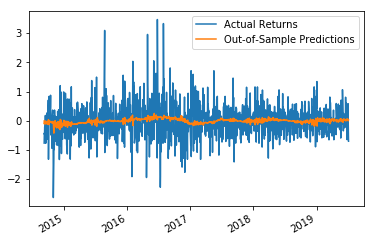

In [85]:
# Plot the results:
# YOUR CODE HERE 

  * Evaluate the model RMSE.
      * Which has the better RMSE--this more robust method, or the single ("one-shot") training and test split just above?

In [86]:
# Calculate the mean_squared_error on the Results DataFrame:
# (This compares the average (squared) difference between actual and model-predicted returns)
rolling_mse = # YOUR CODE HERE 
# Then use that to calculate the Root-Mean-Squared Error (RMSE):
rolling_rmse = # YOUR CODE HERE 
rolling_rmse

0.5738123732985758

In [87]:
# Compare the RMSE from the training-testing single split versus the rolling out-of-sample approach we just did:
# YOUR CODE HERE 

0.40994570155874877

Challenge: Can you calculate the out-of-sample R2? Based on this, should we bet money on this model?

In [89]:
# YOUR CODE HERE 

Out-of-Sample R-squared: -0.022563606609533604
